In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3)

20

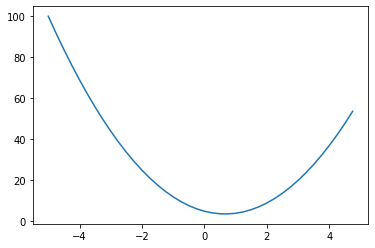

In [4]:
xs = np.arange(-5,5,0.25) # from -5 to 5 with steps of 0.25
# xs

ys = f(xs)
ys

plt.plot(xs, ys)

In [5]:
h = 0.001
x = -3.0
(f(x + h) - f(x)) / h  #diferentiating a function

-21.996999999998934

In [6]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c

d

4.0

In [7]:
h = 0.0001
a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c

a+=h
d2 = a*b + c

print('d1',d1)
print('d2',d2)
print('slope',(d2-d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


# Start by building a data structure

In [186]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        # wraps any integer thats added to a value object as a value object so they can be added
        # eg. a = Value(2.0); a+1; since 1 is not a value object, itll give error
        other = other if isinstance(other, Value) else Value(other)
        
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward(): # chain rule
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other): # value obj * any integer
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        def _backward(): 
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other): # other * self (any integer * value obj will go here)
        return self * other
    
    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def __neg__(self): # -a
        return self * -1
    
    def __sub__(self, other): # a-b
        return self + (-other)
    
    def __radd__(self, other): # other + self
        return self + other
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward(): # chain rule
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
        out._backward = _backward
        
        return out
    
    def backward(self):
    
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [164]:
a = Value(2.0)
b = Value(4.0)
a / b

Value(data=0.5)

In [165]:
a-b

Value(data=-2.0)

In [41]:
# a = Value(2.0, label='a')
# b = Value(-3.0, label='b')
# c = Value(10.0, label='c')
# a,b,c

# e = a+b;e.label = 'e'

# d = a*b + c #(a.__mul__(b)).__add__(c)
# d.label = 'd'
# f = Value(-2.0, label='f')
# L = d*f
# L


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [128]:
a = Value(2.0, label='a')
a+1

Value(data=3.0)

In [42]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  print(nodes)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

{Value(data=-6.0), Value(data=2.0), Value(data=10.0), Value(data=-2.0), Value(data=4.0), Value(data=-8.0), Value(data=-3.0)}


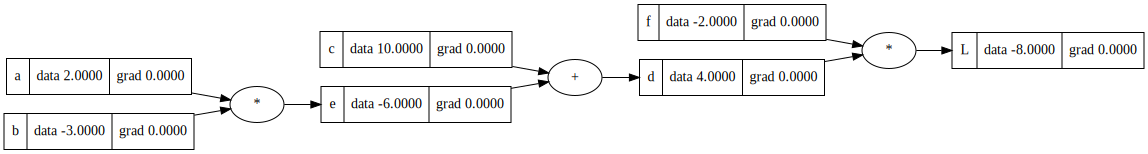

In [43]:
draw_dot(L)

# Computing gradients manually

In [44]:
# calculating gradients thru manual backpropogation

# L = d*f
# dL/dd = f = -2.0
# dL/df = d = 4.0

# this means gradient of d => value of f
# gradient of f => value of d

f.grad = d.data
d.grad = f.data



In [45]:
L.grad = 1.0

In [46]:
# dL / dc

#d = c + e
# dd/dc = 1.0
# dd/de = 1.0

# so we know dd/dc, dd/de, dL/dd and dL/df

# by chain rule => dL/dc = (dL/dd) * (dd/dc)
# we take dd bcz its connected to both nodes in the graph

c.grad = -2.0 # bcz dd/dc = 1, dL/dc = dL/dd * 1 = dL/dd = -2
e.grad = -2.0


In [47]:
# dL/dd = -2.0
# dL/de = -2.0
# dd/de = 1.0

# e = a*b
# de/da = b = -3.0 

# TO FIND OUT: dL/da

# dL/de = (dL/dd) * (dd/de)

# => dL/da = (dL/dd) * (dd/de) * (de/da)
# => dL/da = (dL/de) * (de/da)
# dL/da = -2.0 * -3.0 = 6.0

a.grad = -6.0
b.grad = -4.0 # dL/de * de/db = -2.0 * 2.0 = -4.0

{Value(data=-6.0), Value(data=2.0), Value(data=10.0), Value(data=-2.0), Value(data=4.0), Value(data=-8.0), Value(data=-3.0)}


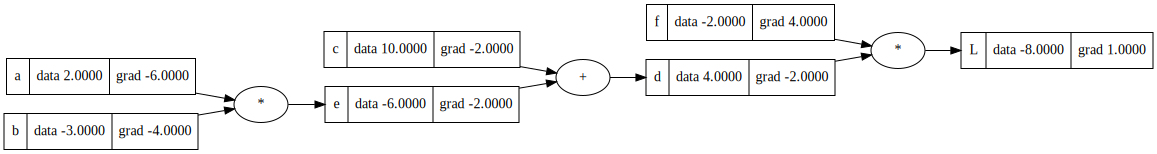

In [48]:
draw_dot(L)

In [49]:
# a.data -= 0.01 + a.grad

a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-8.001504


In [20]:
# use to verify the manual gradient calculated abv

def lol():
    
    h = 0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    a,b,c

    e = a+b;e.label = 'e'

    d = e + c #(a.__mul__(b)).__add__(c)
    d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L1 = L.data
    
    
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    # c.data += h
    a,b,c

    e = a+b;e.label = 'e'
    e.data += h
    d = e + c #(a.__mul__(b)).__add__(c)
    d.label = 'd' 
    # d.data += h
    
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L2 = L.data
    
    print((L2-L1)/h)
    
lol()

-1.9999999999988916


#### essentially, a '+' operator gives both child nodes the same gradient as the parent node


#### a '*' operator multiples the gradient of the parent node and the other child node as its the coefficient
##### a = x*b da/dx = b 

# backprop in a neuron

#### tanh definition
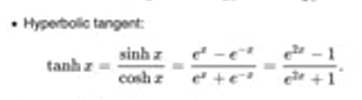

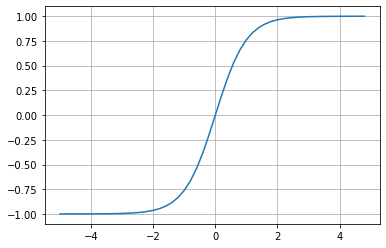

In [60]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid()

In [86]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh()
o.label = 'o'

{Value(data=-6.0), Value(data=0.0), Value(data=0.8813735870195432), Value(data=-6.0), Value(data=-3.0), Value(data=2.0), Value(data=1.0), Value(data=0.0), Value(data=0.7071067811865476), Value(data=6.881373587019543)}


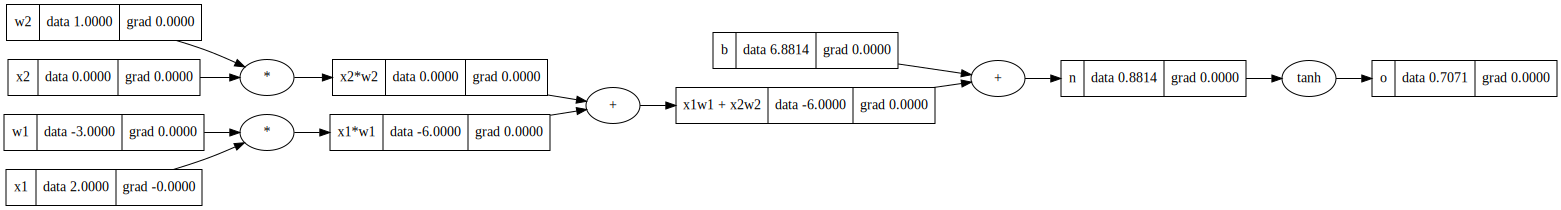

In [87]:
draw_dot(o)

In [72]:
o.grad = 1.0

In [76]:
# o = tanh(n)
# do/dn = 1 - tanh(n)**2 (formula of d/dx of tanh(x))

# do/dn = 1 - o**2


n.grad = 1 - o.data**2 # 0.5

In [78]:
# n = x1w1x2w2 + b 
# dn/dx1w1x2w2 = 1

x1w1x2w2.grad = 0.5 # you get this from n.grad as do/dx1w1x2w2 = 1* do/dn = 0.5 (by chain rule)
b.grad = 0.5

# essentially, a '+' operator gives both child nodes the same gradient as the parent node

In [80]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [83]:
x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data

x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data

{Value(data=1.0), Value(data=-6.0), Value(data=0.0), Value(data=0.7071067811865476), Value(data=-6.0), Value(data=2.0), Value(data=0.8813735870195432), Value(data=6.881373587019543), Value(data=0.0), Value(data=-3.0)}


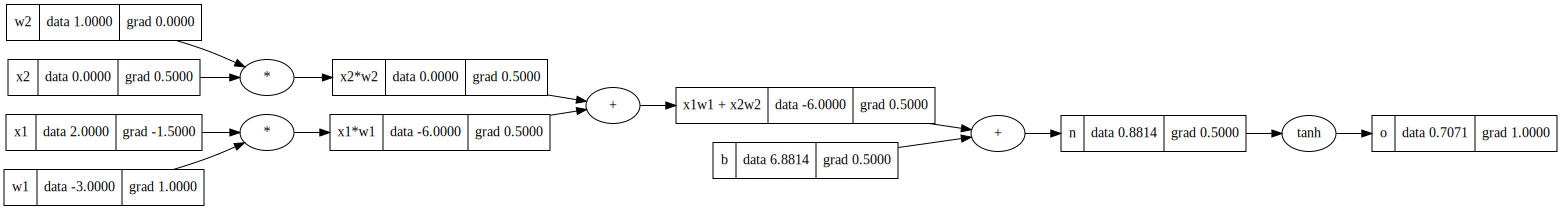

In [84]:
draw_dot(o)

#### automatically calculating the gradient

In [107]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh()
o.label = 'o'

In [108]:
o.grad = 1.0

{Value(data=0.0), Value(data=6.881373587019543), Value(data=-6.0), Value(data=0.0), Value(data=1.0), Value(data=-6.0), Value(data=2.0), Value(data=0.8813735870195432), Value(data=0.7071067811865476), Value(data=-3.0)}


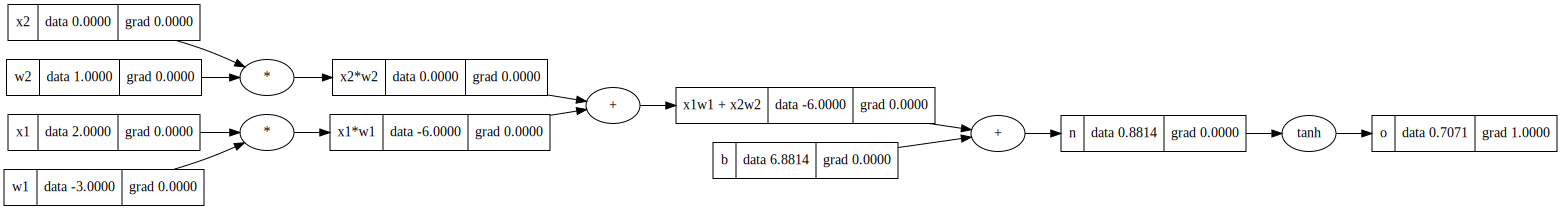

In [109]:
draw_dot(o)

In [112]:
o._backward()
n._backward()
x1w1x2w2._backward()
b._backward() # wont do anything as its a leaf node
x2w2._backward()
x1w1._backward()


{Value(data=0.0), Value(data=6.881373587019543), Value(data=-6.0), Value(data=0.0), Value(data=1.0), Value(data=-6.0), Value(data=2.0), Value(data=0.8813735870195432), Value(data=0.7071067811865476), Value(data=-3.0)}


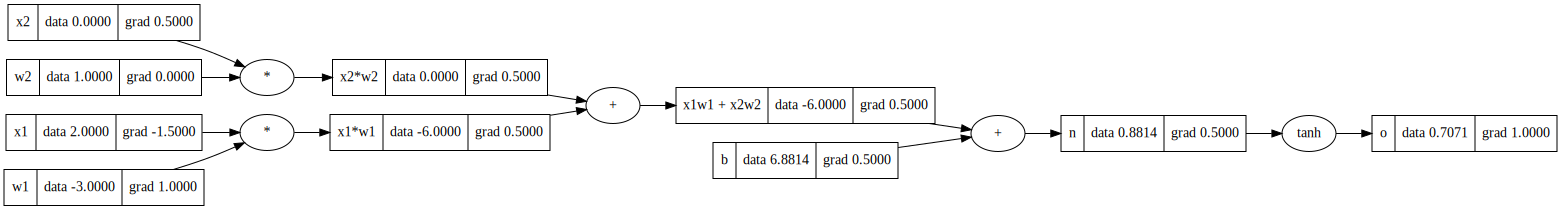

In [113]:
draw_dot(o)

In [115]:

# topological sort to order the nodes/edges
# code to automatically perform backpropogation of nodes
# put in the Value dsa

# topo = []
# visited = set()
# def build_topo(v):
#   if v not in visited:
#     visited.add(v)
#     for child in v._prev:
#       build_topo(child)
#     topo.append(v)
# build_topo(o)
# topo

# for node in reversed(topo):
#   node._backward()

In [116]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh()
o.label = 'o'

{Value(data=0.7071067811865476), Value(data=0.8813735870195432), Value(data=-3.0), Value(data=2.0), Value(data=0.0), Value(data=-6.0), Value(data=-6.0), Value(data=0.0), Value(data=6.881373587019543), Value(data=1.0)}


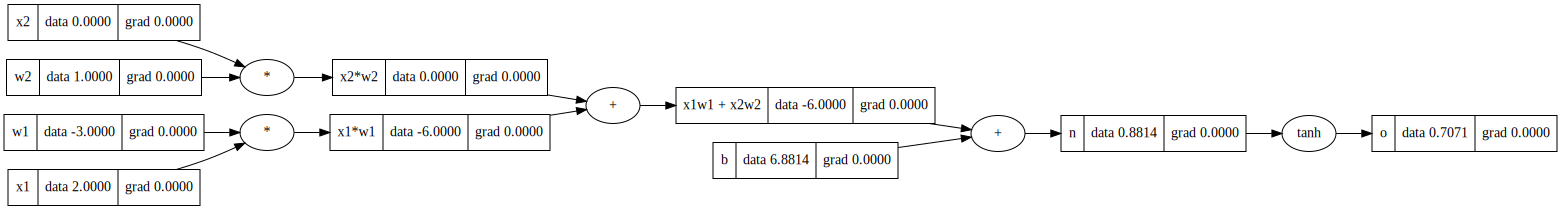

In [117]:
draw_dot(o)

In [118]:
o.backward()

{Value(data=0.7071067811865476), Value(data=0.8813735870195432), Value(data=-3.0), Value(data=2.0), Value(data=0.0), Value(data=-6.0), Value(data=-6.0), Value(data=0.0), Value(data=6.881373587019543), Value(data=1.0)}


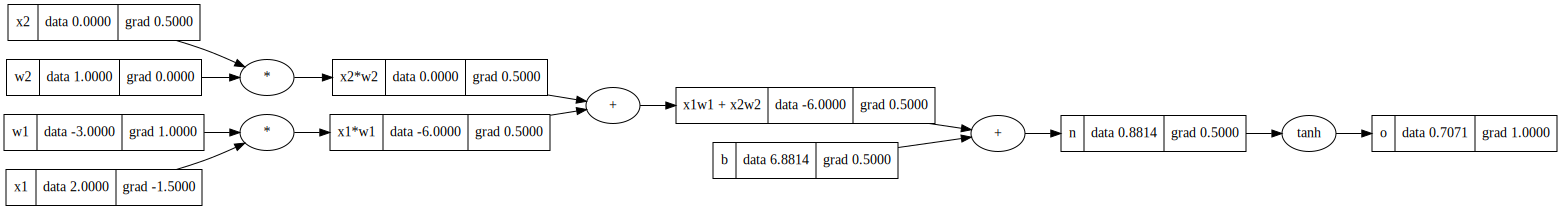

In [119]:
draw_dot(o)

#### bug in the program

{Value(data=6.0), Value(data=3.0)}


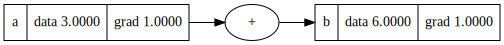

In [122]:
a = Value(3.0, label='a')
b = a + a  #its derivative should be 2 but its not taking that
b.label = 'b'
b.backward()
draw_dot(b)



{Value(data=-2.0), Value(data=-6.0), Value(data=1.0), Value(data=3.0), Value(data=-6.0)}


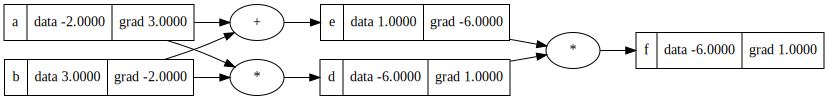

In [123]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

#### after fixing the program

change x.grad = .... to x.grad += .... -> to accumulate/add the gradients in this case

{Value(data=6.0), Value(data=3.0)}


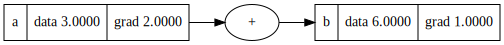

In [126]:
a = Value(3.0, label='a')
b = a + a  #its derivative should be 2 but its not taking that
b.label = 'b'
b.backward()
draw_dot(b)



## breaking up tanh into smaller functions

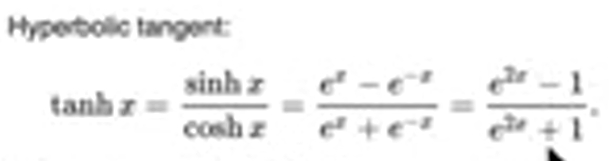

{Value(data=2.0), Value(data=-3.0), Value(data=0.0), Value(data=0.0), Value(data=-6.0), Value(data=0.8813735870195432), Value(data=-6.0), Value(data=0.7071067811865476), Value(data=1.0), Value(data=6.881373587019543)}


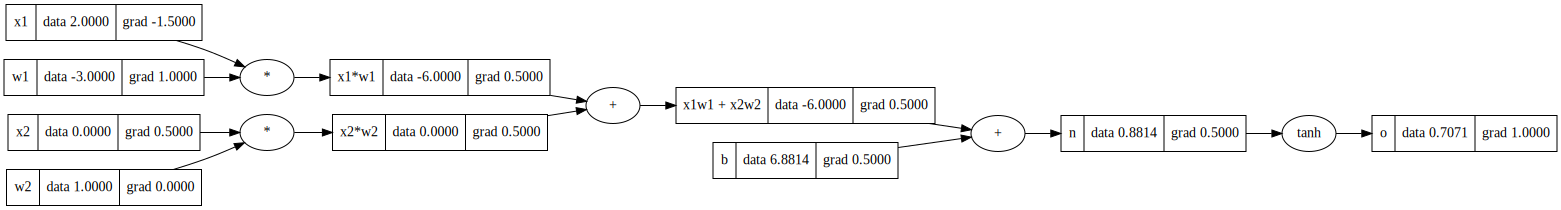

In [166]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh()
o.label = 'o'

o.backward()
draw_dot(o)

{Value(data=1), Value(data=6.881373587019543), Value(data=2.0), Value(data=0.8813735870195432), Value(data=1.0), Value(data=-6.0), Value(data=-3.0), Value(data=-6.0), Value(data=0.0), Value(data=0.0), Value(data=-1), Value(data=6.828427124746192), Value(data=1.7627471740390863), Value(data=0.1464466094067262), Value(data=0.7071067811865477), Value(data=5.828427124746192), Value(data=4.828427124746192), Value(data=2)}


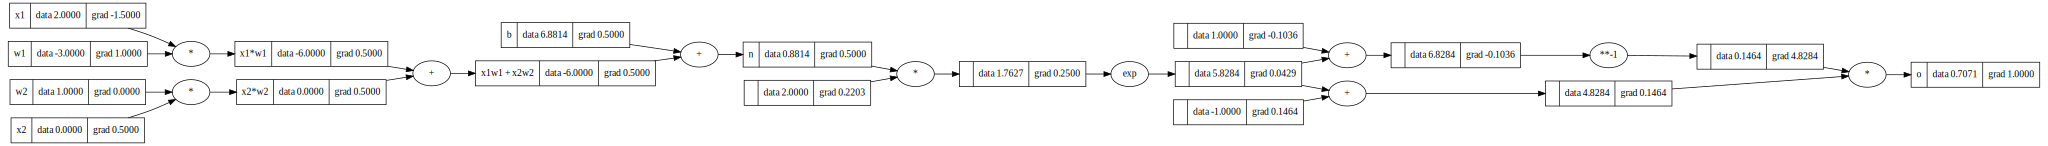

In [167]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp()
o = (e-1) / (e+1)
o.label = 'o'

o.backward()
draw_dot(o)

## getting into implementing with pytorch and tensors

In [169]:
import torch

In [172]:
# torch.Tensor(([1,2,3], [4,5,6]))
torch.Tensor([2.0]).double()

tensor([2.], dtype=torch.float64)

In [175]:
# tensors are by default float32(normal float)
# cast them to double(float64) by .double()
# tensors by default dont require gradients hence need to explicitly state its required
# .item gets the value of the tensor

x1 = torch.Tensor([2.0]).double()                       ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                       ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                      ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                       ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()         ; b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('----')
print('x1', x1.grad.item())
print('x2', x2.grad.item())
print('w1', w1.grad.item())
print('w2', w2.grad.item())


# check if the output gradients match with the implementation before on the graph

0.7071066904050358
----
x1 -1.5000003851533106
x2 0.5000001283844369
w1 1.0000002567688737
w2 0.0


#### the Multi Layer Perceptron (MLP) implemented below is 
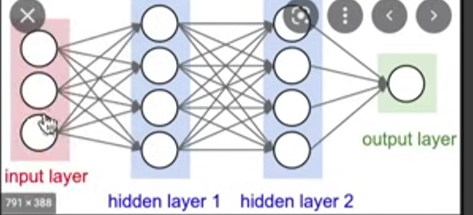

In [236]:
import random


class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        # w * x + b
        
        # print(list(zip(self.w, x))) # zip pairs values from a list and tuple, into a tuple
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) 
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        
        # return [p for neuron in self.neurons for p in neuron.parameters()]
        
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params


class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [237]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=0.5857579672542444)

In [238]:
len(n.parameters())

41

In [239]:
# draw_dot(n(x))

In [255]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]  # actual outputs

ypred = [n(x) for x in xs] # predicted outputs by MLP initially
ypred

[Value(data=0.9629008911384506),
 Value(data=-0.9999828943270797),
 Value(data=-0.9413747122647089),
 Value(data=0.9608834763031597)]

In [256]:
# ygt -> y ground truth which is the actual value
# yout -> y output value(predicted value)

# implementing mean squared loss error which is sum((yout - ygt)**2)
loss = sum([(yout-ygt)**2 for ygt, yout in zip(ys,ypred)] )
loss

Value(data=0.006343370959096278)

In [257]:
## minimise the weights
loss.backward()

In [258]:
n.layers[0].neurons[0].w[0].grad

-7.1129578356597944

In [259]:
n.layers[0].neurons[0].w[0].data

0.794456605398775

In [260]:
# draw_dot(loss)

In [261]:
## minimising the loss
for p in n.parameters():
    p.data += -0.001 * p.grad  # -0.01 as we want to minimise the loss

In [262]:
# value should be closer to actual value
n.layers[0].neurons[0].w[0].data

0.8015695632344348

In [263]:
ypred = [n(x) for x in xs]
loss = sum([(yout-ygt)**2 for ygt, yout in zip(ys,ypred)] )
loss

# new loss

Value(data=0.0049331067692228005)

### used gradient descent to minimize the loss
#### iteratively calling the minimise function and then backpropogating and then calling the loss func should show a decrease


In [273]:
for k in range(10):
    
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout-ygt)**2 for ygt, yout in zip(ys,ypred)] )
    
    #backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    # update
    for p in n.parameters():
        p.data += -0.01 * p.grad
    
    print(k, loss.data)

0 0.002841514318190544
1 0.0028352027732949127
2 0.00282893400350179
3 0.002822707350040539
4 0.0028165221703368997
5 0.002810377837493744
6 0.0028042737397918913
7 0.0027982092802100334
8 0.0027921838759628614
9 0.0027861969580567406


In [274]:
ypred

# values are very close to inital actual values as set

[Value(data=0.9660935530900385),
 Value(data=-0.9999855817912016),
 Value(data=-0.9812161071261415),
 Value(data=0.964171031599872)]